In [ ]:
import os
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningModule, seed_everything
from torch import Tensor, nn
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy, F1Score, MetricCollection, Precision, Recall
from torchvision import transforms
from torchvision.datasets import MNIST

from energizer import Trainer
from energizer.query_strategies import (
    BALDStrategy,
    EntropyStrategy,
    LeastConfidenceStrategy,
    MarginStrategy,
    RandomStrategy,
)

Load and preprocess data, and prepare dataloaders

In [ ]:
data_dir = "../../examples/data"

preprocessing_pipe = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# create train and test sets
train_set = MNIST(data_dir, train=True, download=True, transform=preprocessing_pipe)
test_set = MNIST(data_dir, train=False, download=True, transform=preprocessing_pipe)

# train-val split to create a validation set
train_set, val_set = random_split(train_set, [55000, 5000])

# create dataloaders
batch_size = 32
eval_batch_size = 128  # this is use when evaluating on the pool too
num_workers = os.cpu_count()

# dataloaders
train_dl = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers)
val_dl = DataLoader(val_set, batch_size=eval_batch_size, num_workers=num_workers)
test_dl = DataLoader(test_set, batch_size=eval_batch_size, num_workers=num_workers)

Define the model

In [ ]:
class MNISTCNNModel(LightningModule):
    def __init__(self) -> None:
        super().__init__()

        # create the CNN
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(1024, 128),
            nn.Dropout(),
            nn.Linear(128, self.num_classes),
        )

        # implement metrics
        for stage in ("train", "val", "test"):
            metrics = MetricCollection(
                {
                    "accuracy": Accuracy(),
                    "precision_macro": Precision(
                        num_classes=self.num_classes, average="macro"
                    ),
                    "recall_macro": Recall(
                        num_classes=self.num_classes, average="macro"
                    ),
                    "f1_macro": F1Score(
                        num_classes=self.num_classes, average="macro"
                    ),
                    "f1_micro": F1Score(
                        num_classes=self.num_classes, average="micro"
                    ),
                }
            )
            setattr(self, f"{stage}_metrics", metrics)

    @property
    def num_classes(self) -> int:
        """This is very tailored to MNIST, so hard-code this propoerty."""
        return 10

    def forward(self, batch: Union[Tensor, Tuple[Tensor, Tensor]]) -> Tensor:
        """NOTE: we unpack the batch in forward method. More on this later."""
        if isinstance(x, tuple):
            x, y = batch
            return self.model(x), y
        return self.model(x)

    def common_step(self, batch: Tuple[Tensor, Tensor], stage: str) -> Tensor:
        """For convenience define a common step."""
        logits, y = self(batch)
        loss = F.cross_entropy(logits, y)
        self.log(f"{stage}/loss", loss)
        return loss

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        return self.common_step(batch, "train")

    def validation_step(
        self, batch: Tuple[Tensor, Tensor], batch_idx: int
    ) -> Tensor:
        return self.common_step(batch, "val")

    def test_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        return self.common_step(batch, "test")

    def configure_optimizers(self) -> None:
        return torch.optim.SGD(self.parameters(), lr=0.001)

Instantiate model

In [ ]:
model = MNISTCNNModel()

!!! info "Batch unpacking"
    When passing a model to build a strategy, internally a `deepcopy` will be created. This is done to avoid modifying the model state and passing it around when trying other strategies. It avoids messing up states.

In [ ]:
strategies = {
    "random": RandomStrategy(model),
    "entropy": EntropyStrategy(model),
    "leastconfidence": LeastConfidenceStrategy(model),
    "margin": MarginStrategy(model),
    "bald": BALDStrategy(model),
}

## Active fit

For clarity let's pack the trainer kwargs in a dictionary

In [ ]:
trainer_kwargs = {
    "query_size": 10,  # new instances will be queried at each iteration
    "max_epochs": 3,  # the underlying model will be fit for 3 epochs
    "max_labelling_epochs": 2,  # how many times to run the active learning loop
    "accelerator": "gpu",  # use the gpu
    "test_after_labelling": True,  # since we have a test set, we test after each labelling iteration
    "limit_val_batches": 0,  # do not validate
    "log_every_n_steps": 1,  # we will have a few batches while training, so log on each
}

results_dict = {}

In [ ]:
for name, strategy in strategies.items():
    seed_everything(42)  # for reproducibility (e.g., dropout)
    trainer = Trainer(**trainer_kwargs, enable_progress_bar=False)
    results = trainer.active_fit(
        model=strategy,
        train_dataloaders=train_dl,
        val_dataloaders=val_dl,
        test_dataloaders=test_dl,
    )
    results_dict[name] = results.to_pandas()
    break

### Random strategy

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=random_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)
results_dict["random"] = results.to_pandas()

### Entropy strategy

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=entropy_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)
results_dict["entropy"] = results.to_pandas()

In [ ]:
entropy_df = results.to_pandas()
entropy_df

### Least confidence strategy

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=leastconfidence_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [ ]:
leastconfidence_df = results.to_pandas()
results_dict["leastconfidence"] = leastconfidence_df
leastconfidence_df

### Margin strategy

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=margin_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [ ]:
margin_df = results.to_pandas()
results_dict["margin"] = margin_df
margin_df

### Expected entropy strategy

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=expected_entropy_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [ ]:
expected_entropy_df = results.to_pandas()
results_dict["expected_entropy"] = expected_entropy_df
expected_entropy_df

### Expected margin confidence

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=expected_margin_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [ ]:
expected_margin_df = results.to_pandas()
results_dict["expected_margin"] = expected_margin_df
expected_margin_df

### BALD

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=bald_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [ ]:
bald_df = results.to_pandas()
results_dict["bald"] = bald_df
bald_df

### Results
Now let's look at the results

In [ ]:
for k, v in results_dict.items():
    plt.plot(v["train_size"], v["test/accuracy_epoch"], label=k)
plt.legend()
plt.show()

In [ ]:
for k, v in results_dict.items():
    plt.plot(v["train_size"], v["test/loss_epoch"], label=k)
plt.legend()
plt.show()

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
path = Path("results/bert-base-uncased_agnews/")

dfs = {}
for i in path.iterdir():
    df = pd.read_csv(i)
    dfs[i.name.split(".")[0].replace("bert_", "")] = df

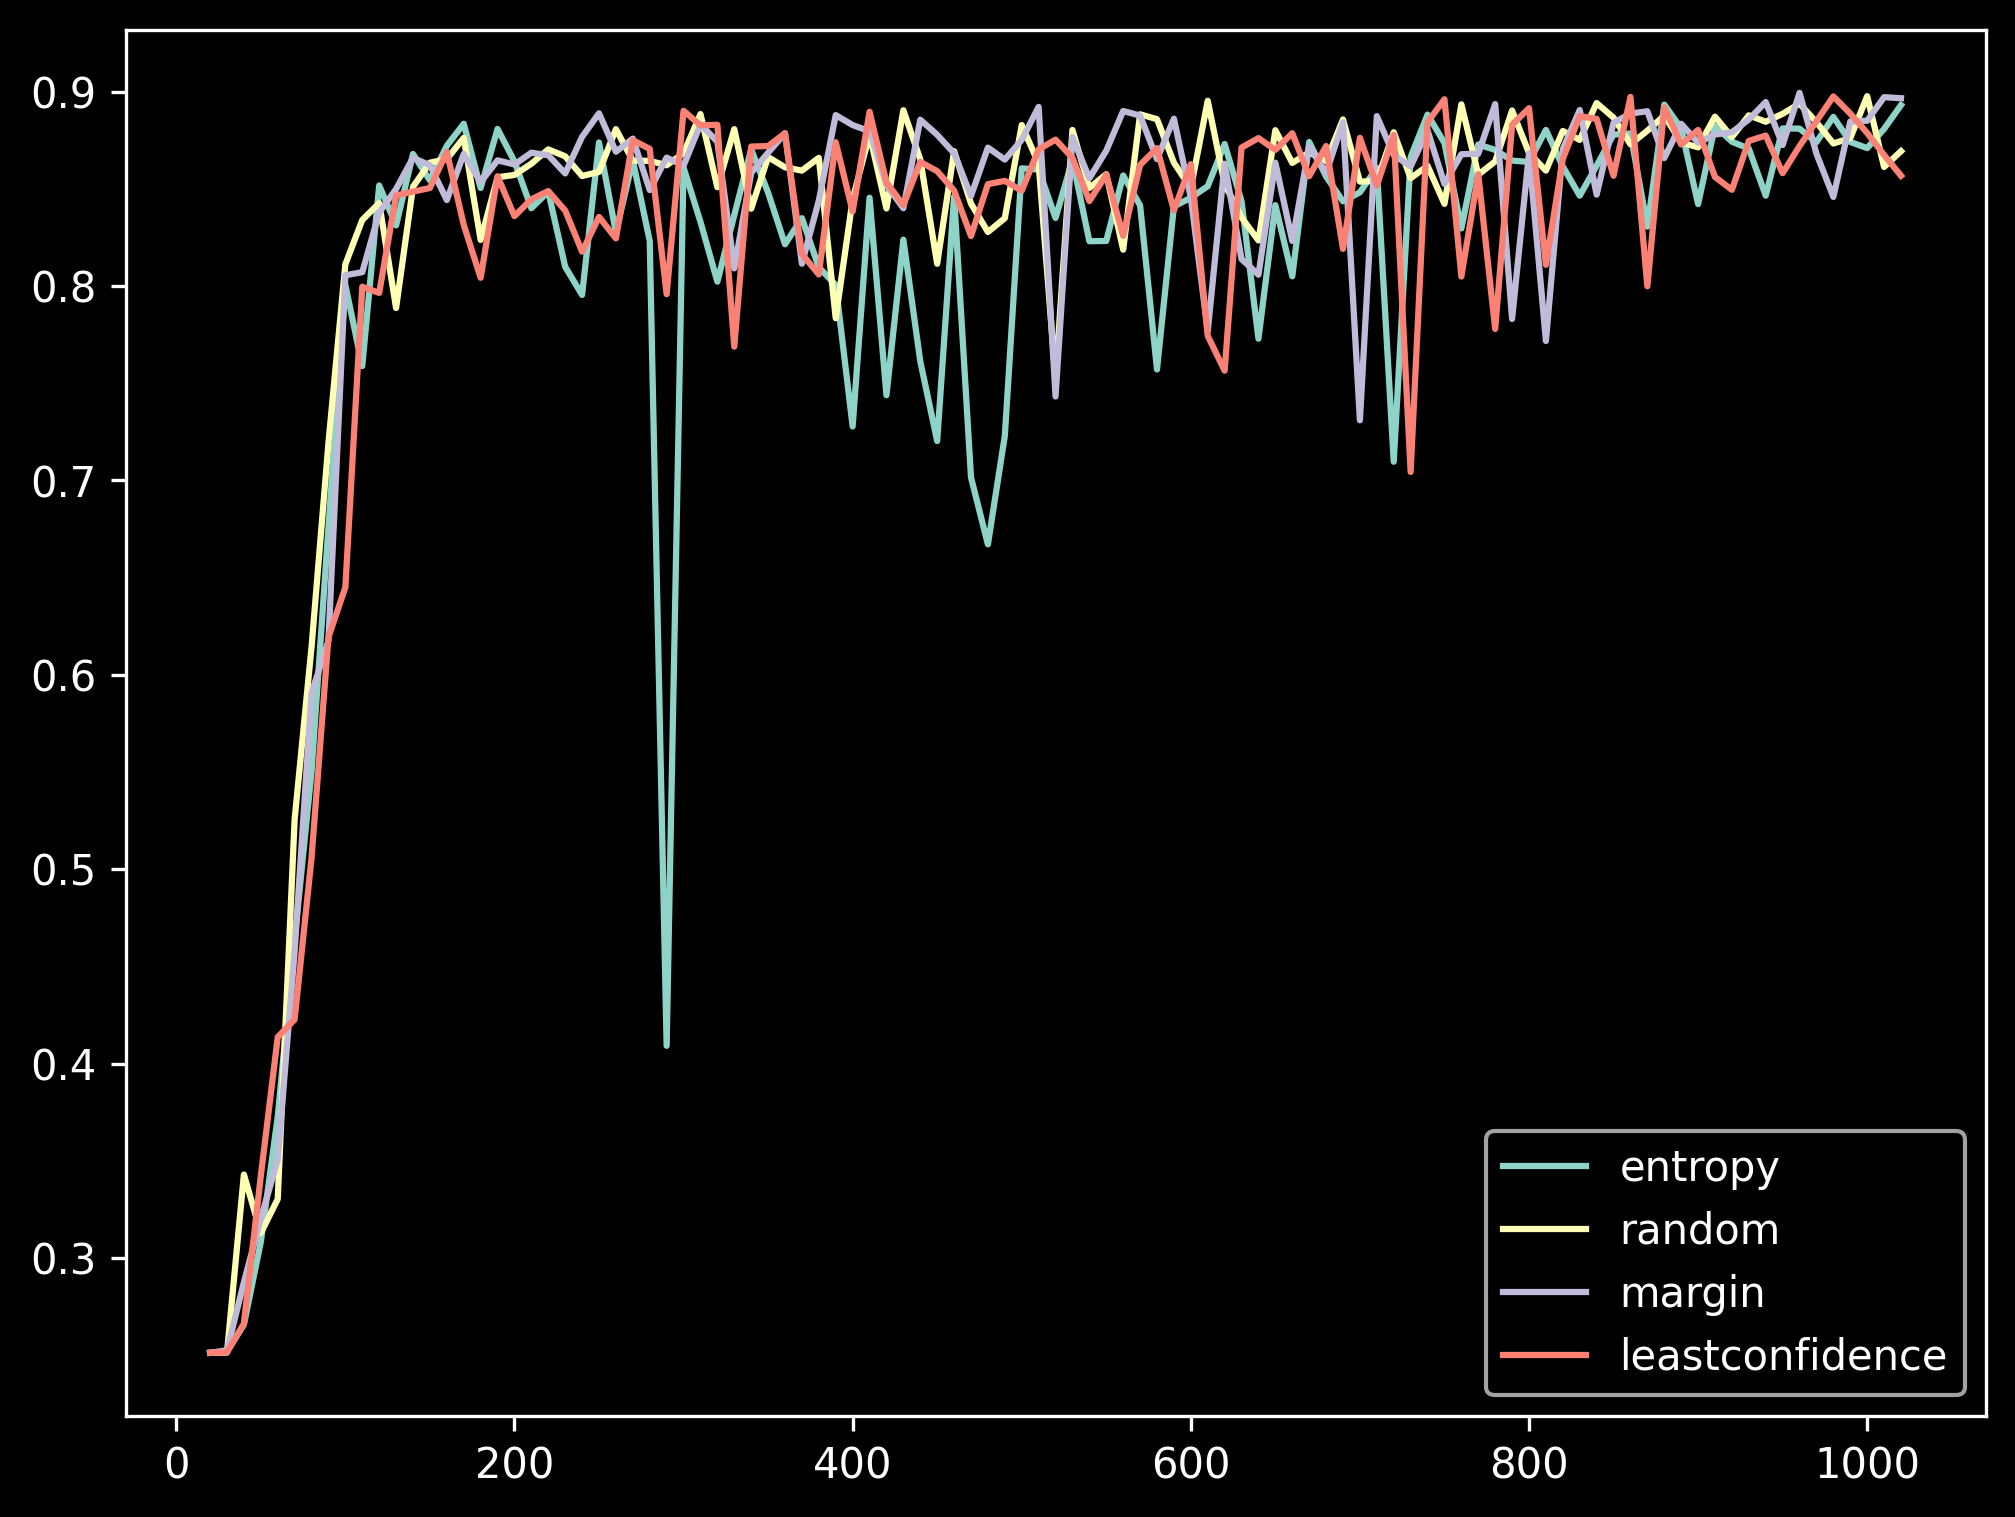

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 300
for k, v in dfs.items():
    plt.plot(v["train_size"], v["accuracy"], label=k)
plt.legend()
plt.show()